# Exercise 2 - CNNs, ResNets and LR-Scheduling

 * Deep Learning for Computer Vision – Winter Term 2024/25

 * Lecture by: Constantin Pape

 * Tutors: Anwai Archit, Oleg Bakumenko, Luca Freckmann, Marei Freitag, Sarah Muth, Sushmita Nair

 * Due date: **Tuesday, Nov 19, before 10:00**

### Time required to solve this exercise sheet

**As you will train a large number of models on this exercise sheet, model training will require an increased amount of time. So we recommend to start working on this sheet early.**

### Topics



In this exercise sheet, you will:

- work again with CIFAR-10

- implement a 1-layer CNN

- compare MLP and CNN

- vary architecture to improve model performance

- implement a ResNet for CIFAR-10

- learn about learning rate scheduling



*We are looking forward to seeing your solutions! Have fun!*

## IMPORTANT SUBMISSION INSTRUCTIONS



- **You need to answer all questions in written form!**

- When you've completed the exercise, download the notebook and rename it to `<surname1>_<surname2>_<surname3>.ipynb`

- Only submit the Jupyter Notebook (.ipynb file). No other file is required.

    - Upload it on `Stud.IP` -> `Deep Learning for Computer Vision` -> `Files` -> `Submission of Homework 2` -> `Tutorial X` (where, X is the tutorial you are assigned to).

- Make only one submission of the exercise per group.

- The deadline is strict.

- You have to present the exercise in the tutorials. We have a high ratio of students to tutors, so please decide which team member presents which part beforehand



Implementation:

- Do not change the cells which are marked as `DO NOT CHANGE`, similarly write your solution into the cells marked with TODOs for the questions asked.

### Imports

In [1]:
import torch

import torch.nn as nn

import torch.nn.functional as F

import torch.optim as optim

from torch.optim.lr_scheduler import ReduceLROnPlateau, ExponentialLR, StepLR

import torchvision

from torchvision import datasets, transforms, models

import fastprogress

import numpy as np

import pandas as pd

import seaborn as sn

import matplotlib.pyplot as plt

import time

## 1. Setup



You can use the functions to grab the data, split the sets, create the dataloaders and plot results, etc. given to you at exercise sheet 1.



It is good practice to store functions that are constantly needed again in a separate file such that instead of copy-pasting the cells into each exercise notebook, you can use the python file containing the functions and import it in the notebooks.



If you work with Kaggle (recommended) you have to mount the drive first and create a path to your python module or download the file from your drive.

#### **TODO**

Create a file named `setup.py` with all the necessary functions. Download this file to your Kaggle workspace and import it on this notebook.



Hint: Use the package `gdown` to download files from google drive.



```python

!conda install -y gdown

!gdown <file_id>

```



Here's how to find the `file_id`: 

If the file URL is https://drive.google.com/file/d/1066jDUxp8fXwdcNGj8h0CWJA0KNLpvKk/view?usp=share_link



where, `file_id` is 2732jDmxp7fXwddNGj8h0CWJA0WWLpvKk

In [2]:
# TODO: Download setup.py from google drive in Kaggle
!conda install -y gdown


Retrieving notices: ...working... done
Channels:
 - rapidsai
 - nvidia
 - nodefaults
 - conda-forge
 - defaults
 - pytorch
Platform: linux-64
Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - gdown


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-24.9.2               |  py310hff52083_0         895 KB  conda-forge
    filelock-3.16.1            |     pyhd8ed1ab_0          17 KB  conda-forge
    gdown-5.2.0                |     pyhd8ed1ab_0          21 KB  conda-forge
    openssl-3.4.0              |       hb9d3cd8_0         2.8 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.7 MB

The following NEW packages will be INSTALLED:

  filelock           conda-forge/noarch::filelock-3.16.1-pyhd8ed1ab_0 
  gdown              conda-forg

In [3]:
# TODO: Import setup.py
!gdown 1066jDUxp8fXwdcNGj8h0CWJA0KNLpvKk

Downloading...
From (original): https://drive.google.com/uc?id=1066jDUxp8fXwdcNGj8h0CWJA0KNLpvKk
From (redirected): https://drive.google.com/uc?id=1066jDUxp8fXwdcNGj8h0CWJA0KNLpvKk&confirm=t&uuid=9b0c0ba1-ee7d-4784-a47f-97b9f815ac4e
To: /kaggle/working/setup.py
100%|██████████████████████████████████████| 16.1k/16.1k [00:00<00:00, 37.2MB/s]


## 2. Load dataset, create dataloader, etc.



#### **TODO**

Call the functions of `setup.py` to instantiate the train-, test- and validation datasets along with their dataloaders.

In [4]:
# TODO: Define device
from setup import *
device = get_device() 
device

device(type='cuda', index=0)

In [5]:
data_dir = 'data'

batch_size = 256



# TODO: Grab data, generate split and initialize data loaders


trainset, testset= grab_data(data_dir)
trainset, valset = generate_train_val_data_split(trainset)
trainloader, valloader, testloader= init_data_loaders(trainset, valset, testset, batch_size)

100%|██████████| 170498071/170498071 [00:04<00:00, 34421816.47it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified
Files already downloaded and verified


#### **TODO** 

Define the loss function. We use the cross entropy loss again.

In [6]:
# TODO: Define loss function
loss_fn = nn.CrossEntropyLoss()


## 3. Simple 1-layer CNN model

**1 Youtube CNN**

- Filter = Kernel = Feature Detector
- Convolution = dot product of filter and original input , results in Feature Map
- different kinds of kernels, ie edge detector (the convolutional matrix then has specific features)
- Pooling: downsample, keep most important parts and discard the rest (reduced spatial size) => detect high level features
- classifiers are then the fully connected layer ( I think they combined the previously detected features)


**2 Youtube CNN**

- In general, pixels are correlated in pictures, e.g. a brown bear -> brown pixels (the bear) is close to other brown pixels, and blue pixels (background, the sky) are close to blue pixels
- we can take advantage of this , ie reduce number of input nodes
- filter takes dot product, we end up wiht feature map
- a filter that takes the max value from the feature map => max pooling; this filter does not overlap, unlike the other filters
- CNNs can handle shifts in pixels, with convolving they still realize the features


Convolution visualization: https://ezyang.github.io/convolution-visualizer/

### **TODO**

- Define the model.



The first step to training a model is defining its architecture. 

Define a sequential model with following structure:

*   Convolutional layer with 32 filters, kernel size of 5*5 and stride of 1.

*   Max Pooling layer with kernel size of 2*2 and default stride.

*   ReLU Activation Layers.

*   Linear layer with output of 512.

*   ReLU Activation Layers.

*   A linear layer with output of 10.

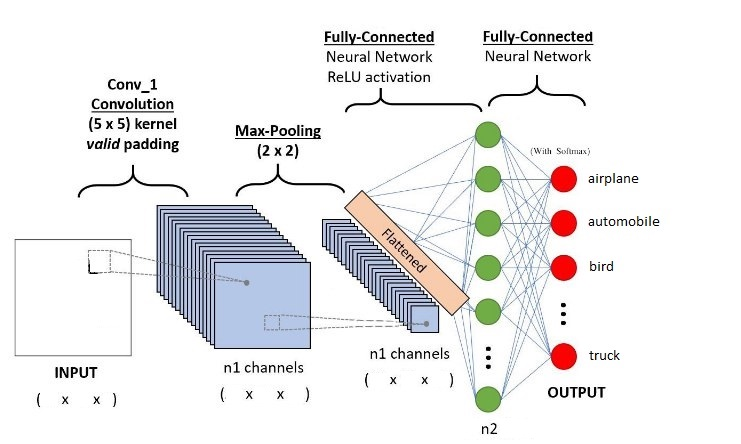

#### **Questions**



- What are the input dimensions?

- What are the dimensions of the feature maps? (Feature map = individual sets of features theat each feature/kernel extracts from the input image)
    - convulutional layer has multiple filters, each scans input and applies convolutional operation, thereby detecting particula type of feature (edge, texture,...) and produces a 2d output matrix that represents where the feature appears in the input => each of these 2D output matrices is called feature map => so multiple filters in convolutional layer, we get multiple feature maps, one for each filter

- What are the dimensions after pooling?

- What is the size of each input (i.e value of `in_features`) to the first fully connected linear layer?

- What is the number of parameters for conv_1?
    - refers to first convolutional layer in the model
    - parameters for a convolution: weights of the filters, biases for each filter (if added)

**Your answers here**

- Input dimensions of 32x32x3 (width_pixels x height_pixels x RGB)
- The dimensions of the feature maps are 28x28x32 => 32 times we have a 28x28 feature map
- The dimensions after pooling are 14x14x32 => Each feature map is pooled, since we use stride 2, we can divide feauture map height/width by stride 28/2 = 14
- we flatten the pooled layer into a 14x14x32 = 6272 1D vector, which is the input for each neuron in the fully connected layer, the reason for why we call it fully connected
- 2432 parameters
    - 32 filters of size 5x5x3 = 75 per filter
    - add + 1 for bias for each filter = 76
    - 32 x 76 = 2432

In [7]:
# TODO: Define model

class CNN(nn.Module):

    # Convolutional layer with 32 filters, kernel size of 5*5 and stride of 1.
    # Max Pooling layer with kernel size of 2*2 and default stride.
    # ReLU Activation Layers.
    # Linear layer with output of 512.
    # ReLU Activation Layers.
    # A linear layer with output of 10.

    # Break down into feature extractor and classifier
    # Feature extractor: 
        # components: convoliutoinal layer, activation, pooling layer
        # transforms the input image into high-dimensioanl representaion that captures essential features
        # reduced and transfomred feature maps as output, that contain local patterns
    # Classifier: 
        # taking the high-dimensional feature representation and predict final output class
        # usually a FCN

    # So caputure general features (hierarchical representation), then combine them and make prediction
    # from locality to globality

    def __init__(self, in_channels=3):
        super(CNN, self).__init__()

        self.feature_extractor = nn.Sequential(
            # 32 filters, each of size 5x5, stride 1 and no padding = (valid padding)
            # stride = step size by which filter moves accros input image, so we move 1 pixel at a time, we do not skip pixels
            # no padding = no extra pixels at the border
            # output of this layer
                # height = ((input size - kernel size) / stride ) + 1 = 32 - 5 / 1 + 1 = 28, same for width
                # so output feature map = 28 x 28 x 32 (because we have 32 filters)
            # in_channels for RGB, 32x32 is only implicitly given by the layer configuratoin and output dimensions
            nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=5, stride=1, padding = 'valid'),
            
            # Kernel size of 2x2 with a stride of 2 (default)
            # output dimensions of this layer
                # Max pooling reduces the spatial dimensions by the kernel size divided by the stride
                # 28x28 input with 2x2 pooling with stride 2 => 28/2 = 14 for height and widht 
                # after pooling, 14x14x32
            nn.MaxPool2d(kernel_size=2),

            # Relu Activation function 
            nn.ReLU(),  
        )
        
        self.classifier = nn.Sequential(
            # flattened input, output as given 512, fully connected layer
            nn.Linear(in_features=14*14*32, out_features = 512),
    
            # relu activation
            nn.ReLU(),
    
            # second fully connected layer with then output with as many classes (10 for CIFAR) as we have
            nn.Linear(in_features = 512, out_features = 10)
        )
        
    def forward(self, x):
        # see output 14x14x32
        x = self.feature_extractor(x)

        # flattens to 1D -> 14x14x32 = 6272, which will be the in_features value for the first linea layer in classifier
        # Better way of flattening, compare to x.view(x.size(0), -1)
            # after feature extractor: (batch size, 32, 14, 14)
            # now we need to convert it into 1D for each item in the batch, ie flatten all dimensions except batch
            # so here we flatten x (all images) but start at dimension 1 (second dimension), keeping batch dimension (0) unchanged
        x = torch.flatten(x,1)
        x = self.classifier(x)
        
        return x




#### **TODO**



- Train the model for 10 epochs. Try lr=0.001 (can be changed to suit other design choices you make)

- Plot the results of accuracy and loss as you did in exercise sheet 1.

Finished training after 108 seconds.


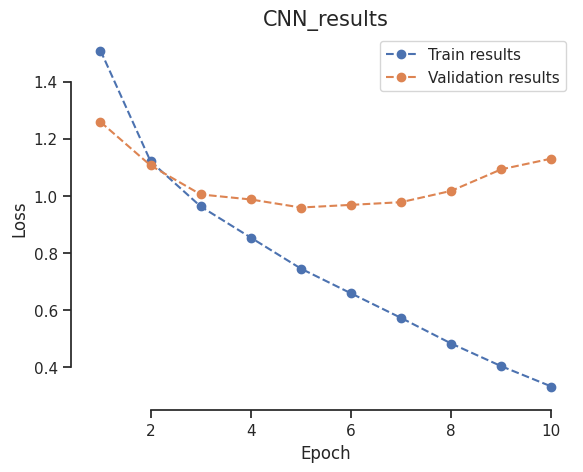

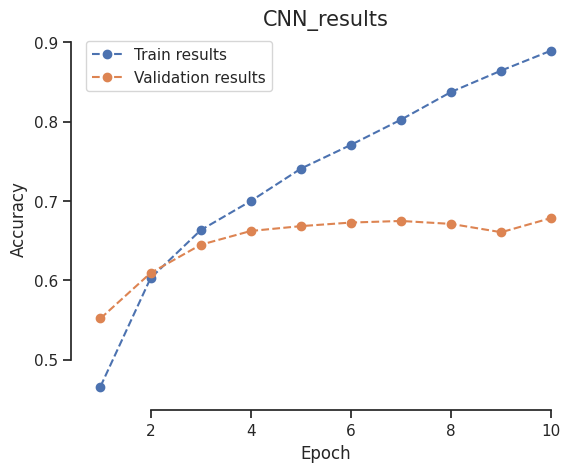

In [8]:
# TODO: Train and plot

model_CNN = CNN()
model_CNN.to(device)

lr = 0.001
num_epochs = 10
optimizer = torch.optim.Adam(model_CNN.parameters(), lr)


##########################################

train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(model_CNN, optimizer, 
                loss_fn, device, num_epochs, trainloader, valloader, early_stopper=None, verbose=False)


plot('CNN_results', 'Loss', train_losses, val_losses, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None)
plot('CNN_results', 'Accuracy', train_accs, val_accs, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None)

#### **TODO**

Compare results to the MLP models you trained in Exercise 1. What can you observe?

**Differences in the Networks:**

- MLP
    - fully connected layers only -> does not capture spacial of pixels relationships through filters, treat each pixel value independently, so making it difficult to understand patterns => work well on data that does not have patterns, simple 1D vectors without any relationship
    - instant flattening of the input image, so any structure in the image is lost, treating pixels independently of its neighbors
- CNN
    - convolution for pattern detection (edges, shapes .. ) thorugh filters, learnign more complex features as we go deeper in the network
    - we first keep the 2D spatial structure of the input image, so we preserve local relationships
    - pooling for dimension reduction, computationally more efficient, less parameters


**Comparison**
- higher accuracy and smaller loss
- by capturing features in a hierarchical manner, less overfit in the CNN (more robust to variations)
- faster, less parameters

**For your reference, below is the loss and accuracy plots of an MLP model trained in Exercise sheet 1:**

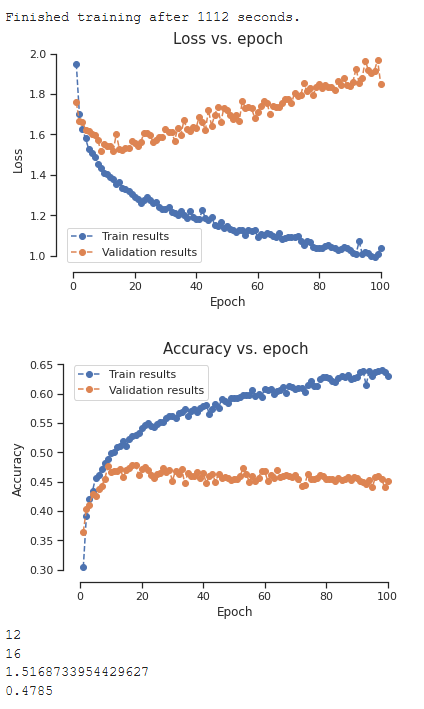

#### **TODO** 

Train longer (ca. 60 epochs), plot again.

Finished training after 641 seconds.


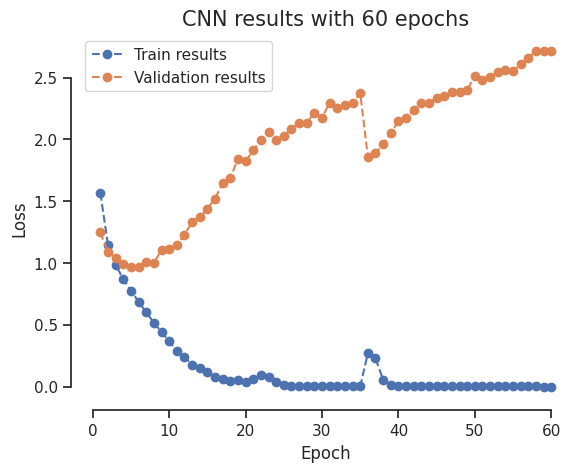

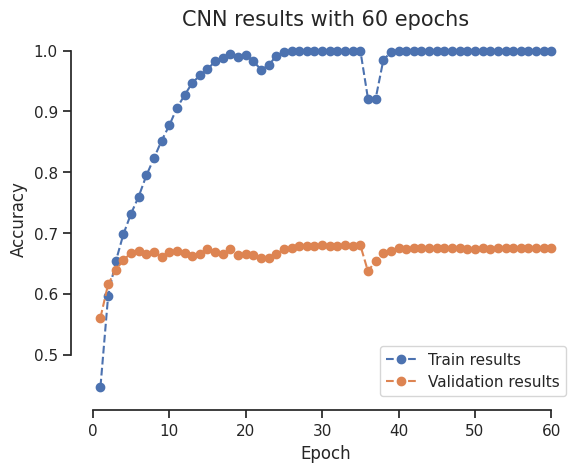

In [9]:
# TODO: Train and plot

# TODO train and plot
model_CNN_60 = CNN()
model_CNN_60.to(device)
optimizer = torch.optim.Adam(model_CNN_60.parameters(), lr)
num_epochs = 60


################################################


train_losses_60, val_losses_60, train_accs_60, val_accs_60, confusion_matrix_60 = run_training(model_CNN_60, optimizer, 
                loss_fn, device, num_epochs, trainloader, valloader, early_stopper=None, verbose=False)
plot('CNN results with 60 epochs', 'Loss', train_losses_60, val_losses_60, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None)

plot('CNN results with 60 epochs', 'Accuracy', train_accs_60, val_accs_60, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None)

#### **Questions**

- Why is that not an optimal model?

- What could be improved?

**Observations**
- training loss decreases significantly and approaches zero by the end of the training
- validation loss increases after epoch 10 -> overfitting (see how validation accuracy plateus but training nearly reaches 100%) -> discrepancy shows how model is not generalizing well to unseen data


**Why it is not optimal**
- overfit
    - only one convolutional layer, only basic features can be captured
    - overfit can happen when model has too many parameters relative to the amount of data/complexity of the problem => single convolutional layer followed by FCL results in high dimensional representation early on, which can make it easy for the model to memorize training data without learning generalizable features.
 
**Improving**
- Adding additional convolutional layers would allow the model to build hierarchical features, starting with basic patterns and progressing to more complex features. This would help the model generalize better to unseen data by learning more representative features of the images.
- adding more pooling reduces the number of parameters in the fully connected layers, making the model more efficient and less prone to overfitting


**Further Improvement**
- data augmentation -> transformation of training data like rotation, flips ... increase variety and improve generelization
- early stopping / reguralization

## 4. CNN model with more convolutional layers

**batchnorm**  
- 


**average pooling**
- take average of the pooling window, output average scalar


**receptive field**
- 



#### **TODO**

Define the architecture using the following information:







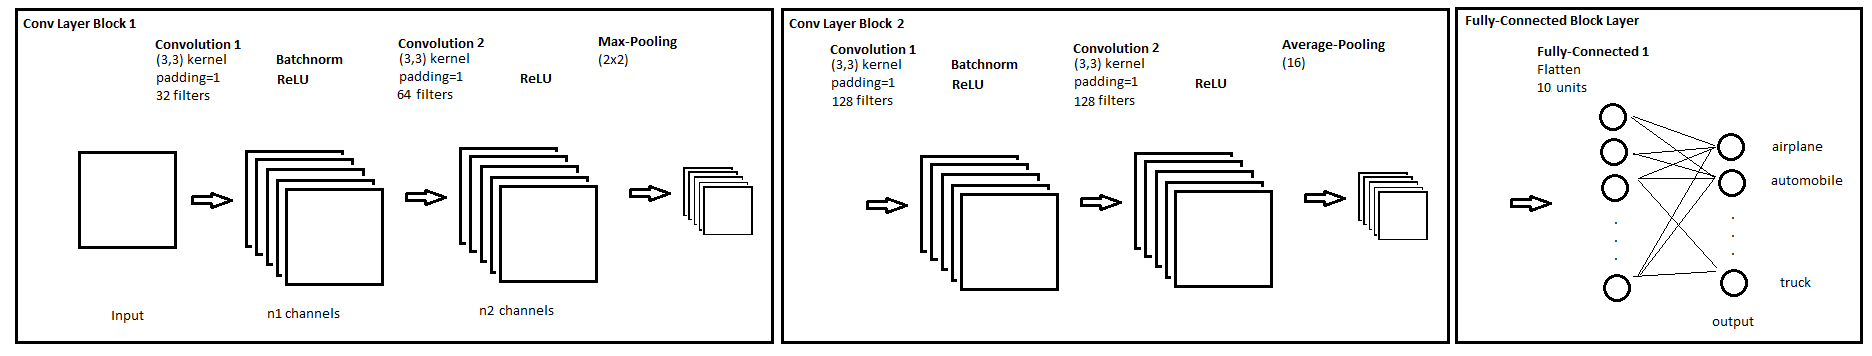

*   Convolutional layer 1: with 32 filters, kernel size of 3*3 and padding 1.

*   Batchnorm and ReLU layers

*   Convolutional layer 2: with 64 filters, kernel size of 3*3 and padding 1.

*   ReLU Activation layer

*   Max pooling with kernel size of 2*2

*   Convolutional layer 3: with 128 filters, kernel size of 3*3 and padding 1.

*   Batchnorm and ReLU layers

*   Convolutional layer 4: with 128 filters, kernel size of 3*3 and padding 1.

*   ReLU Activation layer

*   Average pooling with kernel size 16*16

*   Fully connected layer

#### **Questions**



- Padding is used in the convolutional layers. What does that mean, which variants exist and how does it influence the dimensions of the feature maps?

- What does padding=1 mean in the case of the network displayed above?

- What are the dimensions of the feature maps after the 1. conv layer?

- What are the dimensions of the feature maps after the 2. conv layer?

- What ist the receptive field size after the first two convolutions?

- What is the value for the in_features for the fully-connected layer?

- What is the number of parameters of *Conv Layer block 1*?

**Your answers here**
- Padding = 0 means valid padding i.e. the size of the feature maps gets reduced. Padding = 1 means 'same' padding (for a 3x3 filter) so the feature maps keep the same size. In general padding means we add zeros around the feature map. 
- The feature maps size stays the same. 
- 32x32 for 32 feature maps 
- 32x32 for 64 feature maps
- The rf size = 1 + (k1 -1) + (k2-1) = 5 => k is the kernel size, refer to script formula
- 128
- Parameters conv layer block 1 (without bias): from tutorial: we have to add bias, forgotten here
    - convolution 1: 3x3x3x32 => 32 kernels of 3x3x3 = 864
    - batch normalization layer: add mean and variance for each feature map => 2 x 32 = 64
    - convolutoinal layer 2: 3x3x32 x 64 => 64 filters, each takes the whole convolution 1 cube which is 3x3x32 (32 feature maps) = 18432
    - 864 + 64 + 18432 = 19360


In [10]:
#TODO: Define model 2
class CNN_Large(nn.Module):
    
    def __init__(self, in_channels=3):
        super(CNN_Large, self).__init__()

        # Convolutional layer 1: with 32 filters, kernel size of 3*3 and padding 1.
        # Batchnorm and ReLU layers
        # Convolutional layer 2: with 64 filters, kernel size of 3*3 and padding 1.
        # ReLU Activation layer
        self.block_one = nn.Sequential(
            #input is a 32x32x3 image
            # outout after convd2 is 32x32x32 => 32 filters of same size
            nn.Conv2d(in_channels = in_channels, out_channels=32, kernel_size = 3, stride = 1, padding = 1),

            #does not change dimensions, ie 32x32x32
            nn.BatchNorm2d(32),
            nn.ReLU(),

            #64 filters of size 32x32 => padding keeps the dimensions
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding = 1),
            nn.ReLU()
        )

        # Max pooling with kernel size of 2*2
        # Convolutional layer 3: with 128 filters, kernel size of 3*3 and padding 1.
        # Batchnorm and ReLU layers
        # Convolutional layer 4: with 128 filters, kernel size of 3*3 and padding 1.
        # ReLU Activation layer
        # Average pooling with kernel size 16*16
        self.block_two = nn.Sequential(

            #input from block 1 is 32x32x64
            #output: 16x16x64
            nn.MaxPool2d(kernel_size=2),

            # 16x16x128
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding = 1),

            #does not change dimensions
            nn.BatchNorm2d(128),
            nn.ReLU(),

            #16x16x128
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding = 1),
            nn.ReLU(),

            #entire region is pooled, so 1x1x128
            nn.AvgPool2d(kernel_size = 16)
        )

        # Fully connected layer, flattened below, but 1x1x128 input and outputs 128 1D vector
        self.fcl = nn.Sequential(
            nn.Linear(128,10) 
        )

       
        
    def forward(self, x):
        x = self.block_one(x)
        x = self.block_two(x)
        x = torch.flatten(x,1)
        x = self.fcl(x)
        
        return x




#### **TODO** 



- train the new net (30 epochs, try lr=0.1 or change as necessary), plot the results, and compare the results to the 1-layer CNN

- explain why you observe these results

Finished training after 423 seconds.


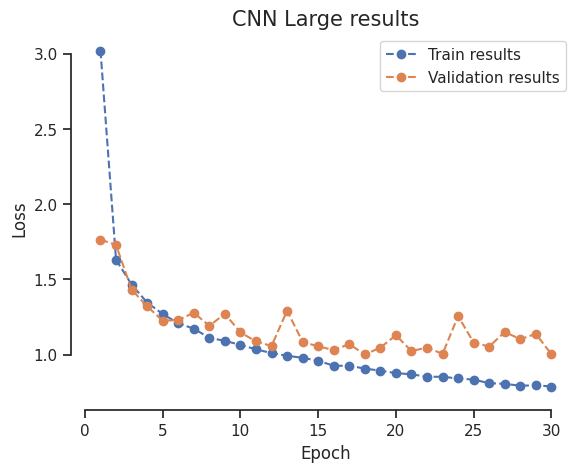

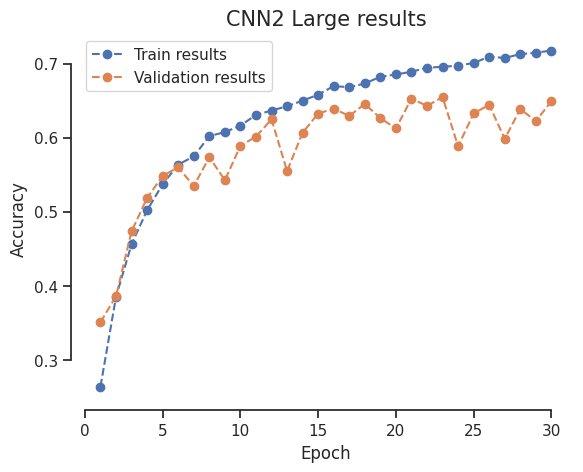

In [11]:
# TODO: Train and plot
model_CNN_large = CNN_Large()
model_CNN_large.to(device)

lr = 0.1
optimizer = torch.optim.Adam(model_CNN_large.parameters(), lr)
num_epochs = 30

train_losses_2, val_losses_2, train_accs_2, val_accs_2, confusion_matrix_2 = run_training(model_CNN_large, optimizer, 
                loss_fn, device, num_epochs, trainloader, valloader, early_stopper=None, verbose=False)

plot('CNN Large results', 'Loss', train_losses_2, val_losses_2, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None)
plot('CNN2 Large results', 'Accuracy', train_accs_2, val_accs_2, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None)

- Compared to our 1-layer CNN the overall loss is higher and therefore the accuracy a bit lower but the model doesn't seem to overfit. Maybe longer training is required due to the additional layers since the gradients need more epochs to propagate. 

## 5. ResNet architecture



"*Deeper neural networks are more difficult to train.  We present a residual learning framework to ease the training of networks that are substantially deeper than those used previously.*" [ https://arxiv.org/pdf/1512.03385.pdf]



That was the intention of He et al. to develop residual networks.



A ResNet is built of blocks which are called the *Residual Blocks*. 

A residual block uses *skip connections* - shortCuts — to jump over some layers to skip some activations.

The Resnet skips connections via addition.



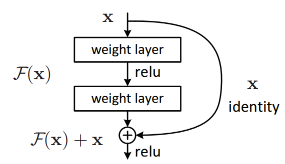

#### **Questions**

- Which problems do using skip connections solve?

- Why is a residual network called residual? 

**Your answers here**
- Enables to train deeper networks more easily, since the residual connections tackle the problem with vanishing gradients. Further the identity mappings do not add any extra parameters, so the network- complexity does not increase.  

- Since the model tries to approximate a residual function.  

#### **TODO**

- write a class **ResidualBlock(nn.Module)** where you define the blocks used in the ResNet

- write a class **ResNet(nn.Module)** where you define the model

- Train the model and plot results

- Train another model by disable residual connections and compare performance

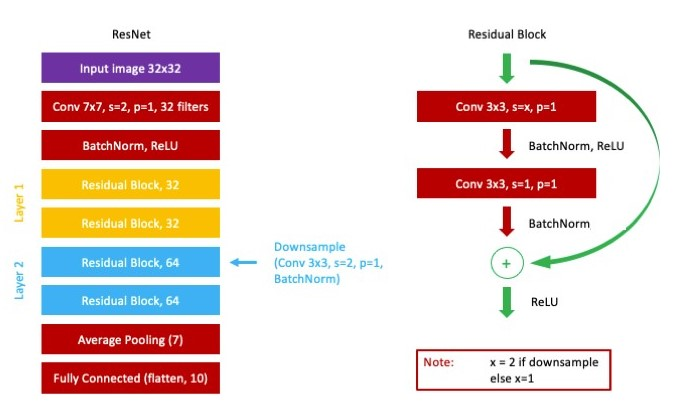

**Hints**



- The downsampling in this ResNet happens between layer 1 and layer 2. In this step, the channel size is increased (32 -> 64) and the image resolution is downsampled by strided convolution (stride=2 in the Conv2d layers).

- For the adding part, the dimensions obviously have to be the same. This is accomplished by using stride=2 in the first Conv2d layer of the block while the second layer does not change the dimensions.

- The average-pooling layer has kernel size 7.

- For you to ensure everything works fine, here are the shapes in the form [(batchsize), x, y, channel] where I discard batchsize, because it does not change.

32x32x3 -> conv 7x7 -> 14x14x32 -> layer 1 -> 14x14x32 -> layer2 -> 7x7x64 -> avpool(7) -> 1x1x64 -> linear(64, 10)

In [12]:
# TODO: Write a class ResidualBlock(nn.Module) where you define the blocks used in the ResNet

class ResidualBlock(nn.Module):
        def __init__(self, downsample, in_channels, out_channels, stride):
            super(ResidualBlock, self).__init__()
            
         

                       
            self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=stride, padding = 1)
            self.bn1= nn.BatchNorm2d(out_channels)
            self.relu = nn.ReLU()
            self.conv2 = nn.Conv2d(in_channels = out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding = 1)
            self.bn2= nn.BatchNorm2d(out_channels)
            
            self.for_downsampling = nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = 1,  stride = stride)
            
            self.downsample = downsample

        
        def forward(self, x):
               
            
            identity = x
            x = self.conv1(x)
            x = self.bn1(x)
            x = self.relu(x)
            x = self.conv2(x)
            x = self.bn2(x)
            
            if self.downsample:
                identity = self.for_downsampling(identity)
                
            x += identity
            x = self.relu(x)
            
            return x
            
        


In [13]:
# TODO: Write a class ResNet(nn.Module) where you define the model

class ResNet(nn.Module):
    def __init__(self, block):
        super(ResNet, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=7, stride=2, padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU()
            )
        
        self.layer0 = self._make_layer(block, downsample=False)
        self.layer1 = self._make_layer(block, downsample = True)
        self.avgpool = nn.AvgPool2d(kernel_size = 7)
        self.Linear = nn.Linear(64,10)
        
        
    def _make_layer(self,block,downsample):
        
        layers=[]
        
        if downsample:
            layers.append(block(downsample, in_channels = 32, out_channels = 64 , stride = 2))
            layers.append(block(downsample, in_channels = 64, out_channels= 64, stride = 1))

                
        else:
            layers.append(block(downsample, in_channels = 32, out_channels= 32, stride = 1))
            layers.append(block(downsample, in_channels = 32, out_channels= 32, stride = 1))
        
        return nn.Sequential(*layers)
            
    
    def forward(self,x):
        
        x = self.conv1(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.avgpool(x)
        
        x= torch.flatten(x,1)
        
        x= self.Linear(x)
        
        return x

In [14]:
# TODO: Train ResNet using the architecture laid out in the comments and figures above. Plot loss and accuracy for training and validation set.

model_res = ResNet(ResidualBlock).to(device)

lr = 0.1

optimizer = torch.optim.Adam(model_res.parameters(), lr)
num_epochs = 30


train_losses_res, val_losses_res, train_accs_res, val_accs_res, confusion_matrix_res = run_training(model_res, optimizer, 
                loss_fn, device, num_epochs, trainloader, valloader, early_stopper=None, verbose=False)

Finished training after 353 seconds.


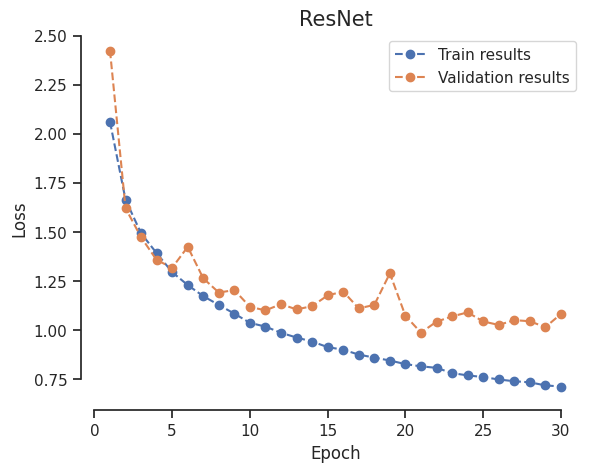

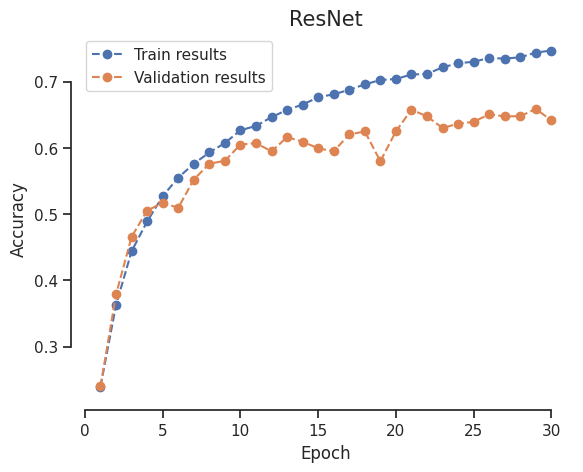

In [15]:
plot('ResNet', 'Loss', train_losses_res, val_losses_res, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None)
plot('ResNet', 'Accuracy', train_accs_res, val_accs_res, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None)

In [16]:
# TODO: Train another model by disabling all residual connections. Plot loss and accuracy curves for training and validation set.

class Block(nn.Module):
        def __init__(self, downsample, in_channels, out_channels, stride):
            super(Block, self).__init__()
            
         

                       
            self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=stride, padding = 1)
            self.bn1= nn.BatchNorm2d(out_channels)
            self.relu = nn.ReLU()
            self.conv2 = nn.Conv2d(in_channels = out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding = 1)
            self.bn2= nn.BatchNorm2d(out_channels)
            

        
        def forward(self, x):
               
            x = self.conv1(x)
            x = self.bn1(x)
            x = self.relu(x)
            x = self.conv2(x)
            x = self.bn2(x)
            x = self.relu(x)
            
            return x
            

In [17]:
model_net = ResNet(Block).to(device)

lr = 0.1

optimizer = torch.optim.Adam(model_net.parameters(), lr)
num_epochs = 30


train_losses_net, val_losses_net, train_accs_net, val_accs_net, confusion_matrix_net = run_training(model_net, optimizer, 
                loss_fn, device, num_epochs, trainloader, valloader, early_stopper=None, verbose=False)

Finished training after 347 seconds.


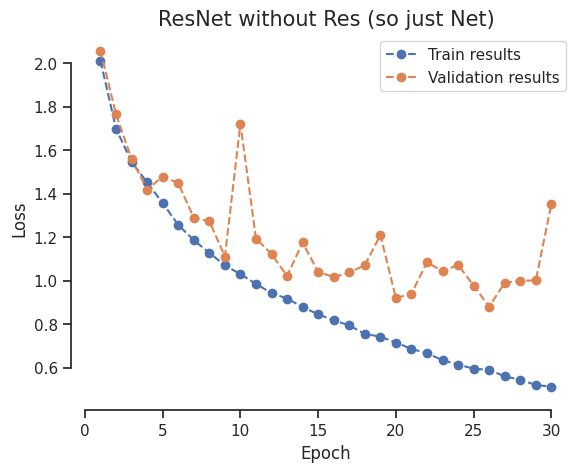

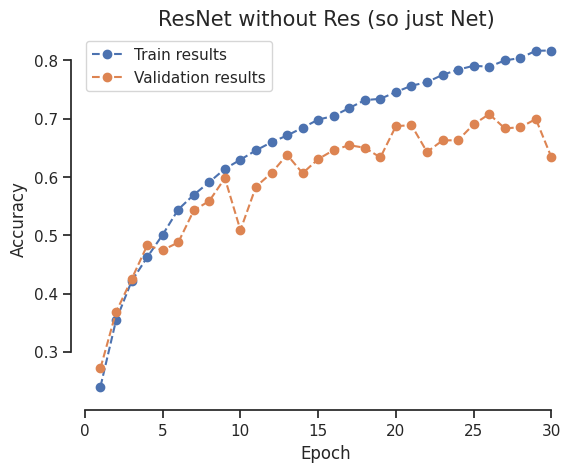

In [18]:
plot('ResNet without Res (so just Net)', 'Loss', train_losses_net, val_losses_net, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None)
plot('ResNet without Res (so just Net)', 'Accuracy', train_accs_net, val_accs_net, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None)

#### **Questions**

- Does using residual connections result in better performance in this exercise? If yes, why? If not, when would the benefit of using ResNet be most visible?

- In deeper networks, how would you expect residual blocks to influence training time? why?

- Compare the performance and training time of your ResNet with the CNNs you trained in the previous section.

**Your answers here**

## 6. Explore Learning Rate Scheduling



Learning rate scheduling is a mechanism to adjust the learning rate.



*`torch.optim.lr_scheduler`* provides several methods based on the number of epochs. Learning rate scheduling should be applied after optimizer’s update.

#### **TODO**

- change run_training and extend to use scheduler for learning rate

- use `StepLR` (https://pytorch.org/docs/stable/optim.html), use the ResNet, train for 10 epochs. Start with a learning rate of 0.1.



#### **Questions**



- Try step size 1, gamma 0.1

    - How does it change the learning rate?

    - what do you observe regarding performance?

- Try step size 1, gamma 0.9, what do you observe?

    - How does it change the learning rate?

    - what do you observe regarding performance?

- What can you conclude of this experiment regarding the synergy of step size and gamma to get a good schedule?

**Your answers here**

In [19]:
# TODO: Change run_training (you can copy the code from setup.py here and create a new method here 

# or just change/create a new method it in the python file)

def run_training_ws(model, optimizer, loss_function, device, num_epochs, 
                train_dataloader, val_dataloader, scheduler, early_stopper=None, verbose=False):
    """Run model training.

    Args:
        model (nn.Module): Torch model to train
        optimizer: Torch optimizer object
        loss_fn: Torch loss function for training
        device (torch.device): Torch device to use for training
        num_epochs (int): Max. number of epochs to train
        train_dataloader (DataLoader): Torch DataLoader object to load the
            training data
        val_dataloader (DataLoader): Torch DataLoader object to load the
            validation data
        early_stopper (EarlyStopper, optional): If passed, model will be trained
            with early stopping. Defaults to None.
        verbose (bool, optional): Print information about model training. 
            Defaults to False.

    Returns:
        list, list, list, list, torch.Tensor shape (10,10): Return list of train
            losses, validation losses, train accuracies, validation accuracies
            per epoch and the confusion matrix evaluated in the last epoch.
    """
    start_time = time.time()
    master_bar = fastprogress.master_bar(range(num_epochs))
    train_losses, val_losses, train_accs, val_accs = [],[],[],[]

    for epoch in master_bar:
        # Train the model
        epoch_train_loss, epoch_train_acc = train(train_dataloader, optimizer, model, 
                                                  loss_function, device, master_bar)
        
        scheduler.step()
        # Validate the model
        epoch_val_loss, epoch_val_acc, confusion_matrix = validate(val_dataloader, 
                                                                   model, loss_function, 
                                                                   device, master_bar)

        # Save loss and acc for plotting
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        train_accs.append(epoch_train_acc)
        val_accs.append(epoch_val_acc)
        
        if verbose:
            master_bar.write(f'Train loss: {epoch_train_loss:.2f}, val loss: {epoch_val_loss:.2f}, train acc: {epoch_train_acc:.3f}, val acc {epoch_val_acc:.3f}')
            
        if early_stopper:
            early_stopper.update(epoch_val_acc, model)
            if early_stopper.early_stop:
                model = early_stopper.load_checkpoint(model)
                print('early stopping')
                break
            # END OF YOUR CODE #
            
    time_elapsed = np.round(time.time() - start_time, 0).astype(int)
    print(f'Finished training after {time_elapsed} seconds.')
    return train_losses, val_losses, train_accs, val_accs, confusion_matrix




In [20]:
# TODO: Train and plot with step size 1, gamma 0.1

import torch.optim.lr_scheduler as lr_scheduler

model_s1 = ResNet(ResidualBlock).to(device)

lr = 0.1

optimizer = torch.optim.Adam(model_s1.parameters(), lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size = 1, gamma = 0.1)
num_epochs = 10


train_losses_scheduler1, val_losses_scheduler1, train_accs_scheduler1, val_accs_scheduler1, confusion_matrix_scheduler1 = run_training_ws(model_s1, 
                                optimizer, loss_fn, device, num_epochs, trainloader, valloader, scheduler, early_stopper=None, verbose=False)

Finished training after 117 seconds.


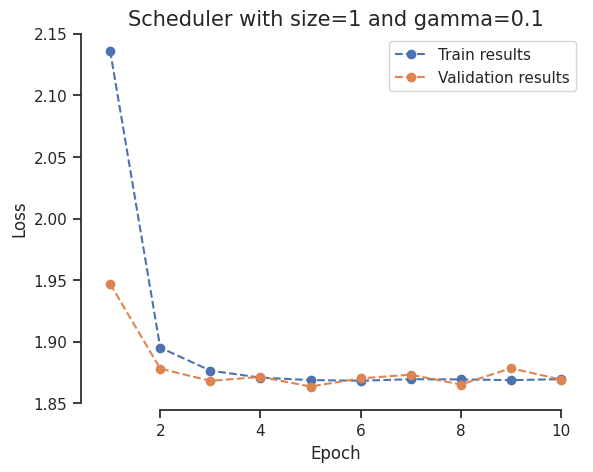

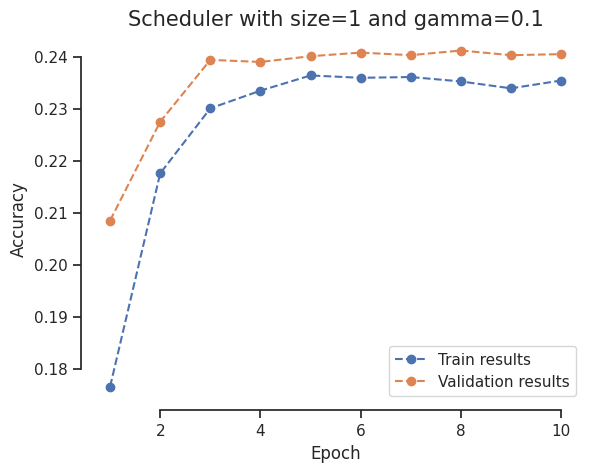

In [21]:
plot('Scheduler with size=1 and gamma=0.1', 'Loss', train_losses_scheduler1, val_losses_scheduler1, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None)
plot('Scheduler with size=1 and gamma=0.1', 'Accuracy', train_accs_scheduler1, val_accs_scheduler1, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None)

In [22]:
# TODO: Train and plot with step size 1, gamma 0.9

model_s2 = ResNet(ResidualBlock).to(device)

lr = 0.1

optimizer = torch.optim.Adam(model_s2.parameters(), lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size = 1, gamma = 0.9)
num_epochs = 10


train_losses_scheduler2, val_losses_scheduler2, train_accs_scheduler2, val_accs_scheduler2, confusion_matrix_scheduler2 = run_training_ws(model_s2, 
                                optimizer, loss_fn, device, num_epochs, trainloader, valloader, scheduler, early_stopper=None, verbose=False)

Finished training after 118 seconds.


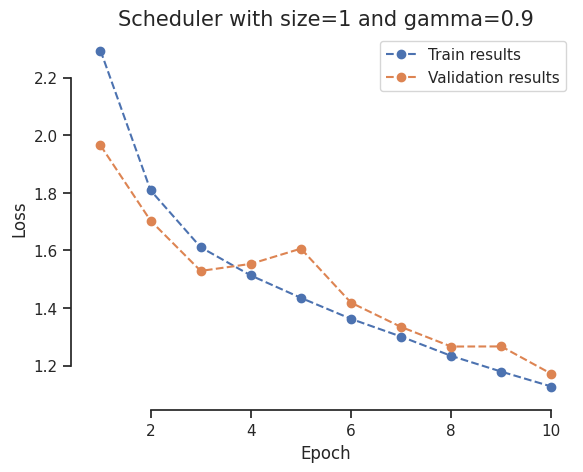

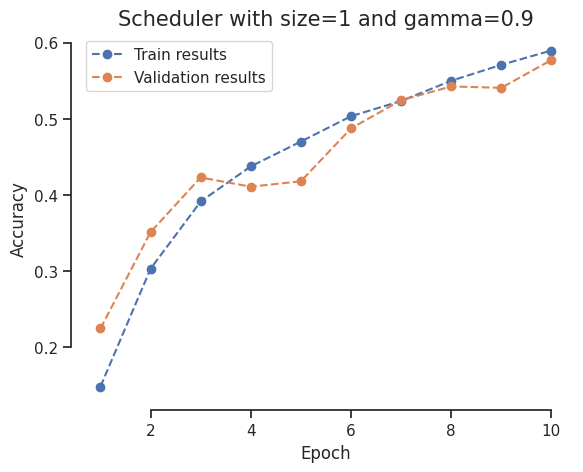

In [23]:
plot('Scheduler with size=1 and gamma=0.9', 'Loss', train_losses_scheduler2, val_losses_scheduler2, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None)
plot('Scheduler with size=1 and gamma=0.9', 'Accuracy', train_accs_scheduler2, val_accs_scheduler2, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None)

#### **TODO** 



Use step size 15, gamma 0.1. Train for 30 epochs.

In [24]:
# TODO: Train and plot with step size 15, gamma 0.1, 30 epochs.

model_s3 = ResNet(ResidualBlock).to(device)

lr = 0.1

optimizer = torch.optim.Adam(model_s3.parameters(), lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size = 15, gamma = 0.1)
num_epochs = 30


train_losses_scheduler3, val_losses_scheduler3, train_accs_scheduler3, val_accs_scheduler3, confusion_matrix_scheduler3 = run_training_ws(model_s3, 
                                optimizer, loss_fn, device, num_epochs, trainloader, valloader, scheduler, early_stopper=None, verbose=False)

Finished training after 355 seconds.


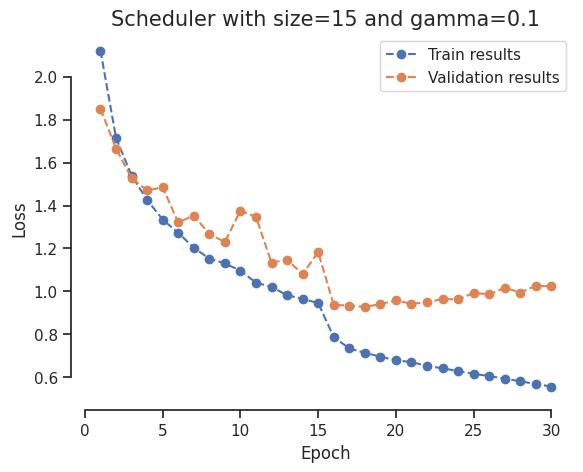

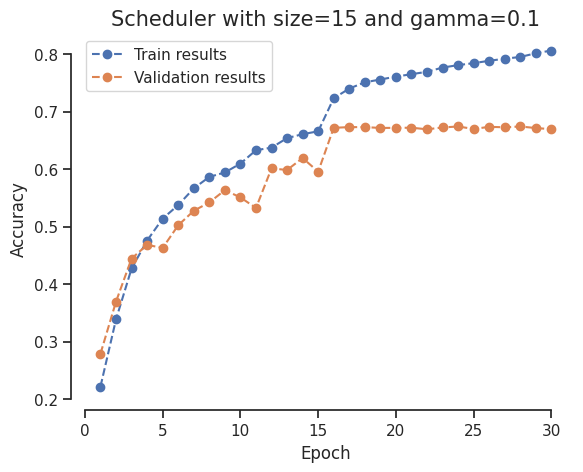

In [25]:
plot('Scheduler with size=15 and gamma=0.1', 'Loss', train_losses_scheduler3, val_losses_scheduler3, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None)
plot('Scheduler with size=15 and gamma=0.1', 'Accuracy', train_accs_scheduler3, val_accs_scheduler3, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None)

#### **Questions**

- Does it improve performance?

- What can you observe in the plots?

**Your answers here**

## 7. LR-Scheduling _(Optional)_

#### TODO _(Optional)_

- try two more scheduler: ExponentialLR and ReduceLROnPlateau 

- vary the parameters, which work best?

- does it improve performance compared to no scheduler?

- does it improve performance compared to StepLR?

In [26]:
# TODO (Optional): Train and plot with different schedulers

**Your answers here**